## Multi Armed Bandit

Combine exploration with exploitation

Instead of an A/B test, where you run the test, then select the best alternative and run with it, **MAB** optimizes and drives more traffic to the best alternative *while* running the test, hence reducing costs (regret)

<img src="images/MAB.png" width=500px>

### Upper Confidence Bound

#### Steps:

Ref: https://www.youtube.com/watch?v=TIlDzLZPyhY

There are `K` arms

`Q(j)` is the expected payoff (between 0 and 1)

1. Play each arm atleast once.
2. Repeatedly play the arm that maximizes $Q(j) + \sqrt{\frac{\frac{3}{2}\ln n}{n_j}}$  where $n_j$ is the number of times you have played arm J and $n$ is the total no. of times you have played.



#### Steps:

1. Assume a starting point for all bandits (distribution) empirically
2. Assume a large confidence band
3. Try each bandit a few times (atleast once)
4. Pick the bandit with the highest confidence band (if multiple same, pick randomly)
5. Run that specific machine again. Shrink its confidence band and move the starting point towards the average reward for that machine till the current step
6. Repeat steps 4 and 5 for `n` iterations
7. After some time, the highest confidence band bandit will come out on top and will keep being used again and again

<img src="images/UCB_Steps.png" width=500px>

### Thompson Sampling

Reference video: https://www.youtube.com/watch?v=p701cYQeqew

#### Steps:

1. Run each machine a few number of times
2. From the values for each machine, create an expected distribution of where the actual central distribution of each machine may lie (as in image) (actual central dist. are the vertical lines. The model doesn't know this)
3. Pull a value from each of the distributions (the `X`s in the image)
4. Select the highest value (green) and pull the lever. This will give us a value (possibly different from the X previously selected)
5. Now add the new pulled point to the dist. for the winner variant, and update its curve
6. Slowly, the best machine will get more and more refined and get selected more frequently.


<img src="images/ThompsonSampling.png" width=500px>

<img src="images/TS_Algo.png" width=500px>

### Comparing UCB and Thompson:

1. Thompson Sampling is **probabilistic**, as compared to UCB which is **deterministic** (no randomness)
2. UCB **has** to be updated every round, whereas TS can accomodate delayed feedback
3. TS usually works better than UCB

# Code

In [4]:
import IPython

In [5]:
import pandas as pd
import random
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [6]:
sns.set(style="darkgrid")

## Creating dummy data

In [70]:
N_USERS = 5000

In [71]:
def random_positive(n, pos_rate):
    '''
    Function to generate a list of length n with 0s and 1s according to pos_rate
    Ratio of 1s to 0s will be approximately pos_rate
    '''
    l = []
    for i in range(n):
        if(random.randint(0, 1000)/1000 < pos_rate):
            l.append(1)
        else:
            l.append(0)
    return l

In [72]:
# Click rates for each ad
probs = [0.12, 0.14, 0.10, 0.11]

In [74]:
columns = ['Ad 1', 'Ad 2', 'Ad 3', 'Ad 4']
df = pd.DataFrame()
for col in range(len(columns)):
    df[columns[col]] = random_positive(N_USERS, probs[col])

### Sample data:

Each row is a user. There are 5000 users, each of them are shown 4 variants of an ad.

1 means they clicked that ad, 0 means they didn't.

In [76]:
df.head()

,Ad 1,Ad 2,Ad 3,Ad 4
0,1,0,0,0
1,0,1,0,1
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0


In [77]:
df.sum()

Ad 1    577
Ad 2    676
Ad 3    503
Ad 4    532
dtype: int64

In [78]:
df.to_csv("sample_data.csv", index=False)

In [79]:
# df = pd.read_csv("sample_data.csv")

Ad **2** has the best performance, this information is not known before hand

Ad 1 also has good performance

If this information was known before hand, the marketer would show variant 2 to all users, and get the highest CTR possible

Our aim is to maximize number of clicks while exploring which variant is the best 

### Random selection

If we select variants at random:

In [84]:
N = df.shape[0]
bandits = df.shape[1]
ads_selected = []
total_reward = 0

for n in range(0, N):
    # selecting a random number between 0 and 3 (since 4 ads)
    ad = random.randrange(bandits)
    ads_selected.append(ad)
    reward = df.values[n, ad]
    total_reward = total_reward + reward

In [85]:
dftemp = pd.DataFrame(pd.Series(ads_selected).value_counts()).reset_index()

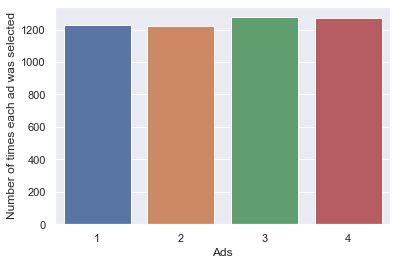

In [86]:
ax = sns.barplot(data=dftemp, x='index', y=0)
ax.set(xlabel='Ads', ylabel='Number of times each ad was selected')
ax.set_xticks(range(0, 4))
ax.set_xticklabels(list(range(1, 5)))
plt.show()

In [87]:
total_reward

531

In [88]:
random_reward = total_reward

### Random selection AB test

In [89]:
adwise_rewards = [0] * bandits
adwise_selection = [0] * bandits

For 10% of the experiment we select random ads

In [114]:
N = df.shape[0]
bandits = df.shape[1]
ads_selected = []
total_reward = 0

adwise_rewards = [0] * bandits
for n in range(0, round(0.1*N)):
    ad = random.randrange(bandits)
    ads_selected.append(ad)
    adwise_selection[ad] += 1
    reward = df.values[n, ad]
    adwise_rewards[ad] += reward
    total_reward = total_reward + reward

In [115]:
adwise_rewards

[15, 14, 12, 14]

In [116]:
adwise_selection

[1420, 1363, 1371, 1346]

In [117]:
ad_reward_rates_yet = [i/j for i, j in zip(adwise_rewards, adwise_selection)]

In [118]:
ad_reward_rates_yet

[0.01056338028169014,
 0.010271460014673514,
 0.0087527352297593,
 0.010401188707280832]

In [119]:
# [0.132, 0.10727969348659004, 0.13135593220338984, 0.1225296442687747]

click_rates = pd.DataFrame()
click_rates['Ad'] = [1,2,3,4]
click_rates['Click Rates For Ad'] = [x*100 for x in ad_reward_rates_yet]
click_rates['Click Rates For Ad'] = [str(round(x, 2)) + "%" for x in click_rates['Click Rates For Ad']]
click_rates = click_rates.round(3)
click_rates

,Ad,Click Rates For Ad
0,1,1.06%
1,2,1.03%
2,3,0.88%
3,4,1.04%


In [120]:
best_ad_yet = ad_reward_rates_yet.index(max(ad_reward_rates_yet))

In [121]:
best_ad_yet

0

1st ad has been selected as the best (this can change every run since random ads are selected for first 10% of the experiment)

In [122]:
total_reward

55

**Now showing ad 1 to all the remaining users**

In [123]:
for n in range(round(0.1*N), N):
    ad = best_ad_yet
    ads_selected.append(best_ad_yet)
    reward = df.values[n, ad]
    total_reward = total_reward + reward

In [124]:
selected = pd.Series(ads_selected).value_counts()
selected.index = selected.index + 1
selected = selected.reset_index().sort_values(by=['index'])
selected.rename({'index': 'Ad'}, axis=1, inplace=True)
selected.rename({0: 'Number of Times Selected'}, axis=1)

,Ad,Number of Times Selected
0,1,4638
2,2,122
1,3,131
3,4,109


In [125]:
total_reward

574

### Thompson

In [159]:
x = np.linspace(0, 1.0, 200)

N = df.shape[0]

d = df.shape[1]

In [160]:
df.sum()

Ad 1    577
Ad 2    676
Ad 3    503
Ad 4    532
dtype: int64

In [161]:
from scipy.stats import beta

In [162]:
# %%timeit

# random.betavariate(1000000000, 1000000000)

In [163]:
N

5000

In [164]:
# Increase PLOTTING_AT_EVERY_N to update plot less frequently
PLOTTING_AT_EVERY_N = 200

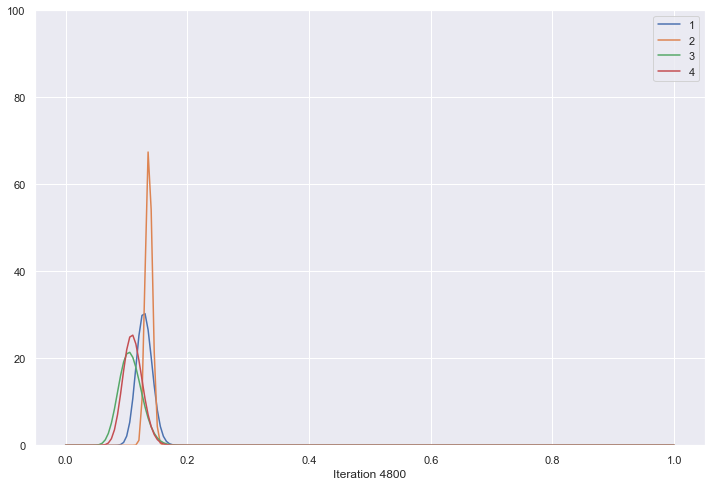

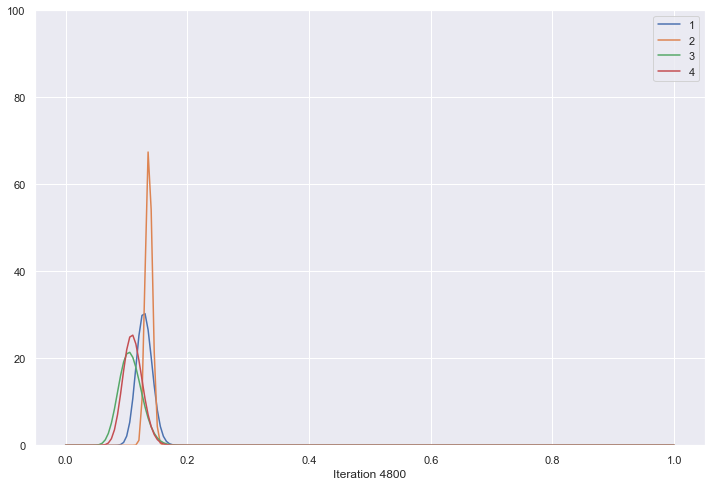

In [165]:
SHOW_PLOT = True

ads_selected = []
number_of_wins = [0] * d
number_of_losses = [0] * d
total_reward = 0
# for n in range(0, N):
fig, ax = plt.subplots(figsize=(12, 8))

for n in tqdm(range(0, N)):
    if(SHOW_PLOT):
        if(n % PLOTTING_AT_EVERY_N == 0):
            ax.cla()
            print(n)
            print()
            print()
            for i in range(0, d):
                sns.lineplot(x=x, y=beta.pdf(
                    x, number_of_wins[i] + 1, number_of_losses[i] + 1), label=str(i+1), ax=ax,
                            )
                ax.set(ylim=(0, 100))
                ax.set(xlabel="Iteration " + str(n))
            IPython.display.clear_output(wait=True)
            IPython.display.display(plt.gcf())
    #         IPython.display.display()
#             time.sleep(0.01)

    ad = 0
    max_random = 0
    for i in range(0, d):
        random_beta = random.betavariate(
            number_of_wins[i] + 1, number_of_losses[i] + 1)
        if random_beta > max_random:
            max_random = random_beta
            ad = i
    ads_selected.append(ad)
#     reward = df.values[n, ad]
    reward = df.values[n, ad]
    if reward == 1:
        number_of_wins[ad] = number_of_wins[ad] + 1
    else:
        number_of_losses[ad] = number_of_losses[ad] + 1
    total_reward = total_reward + reward

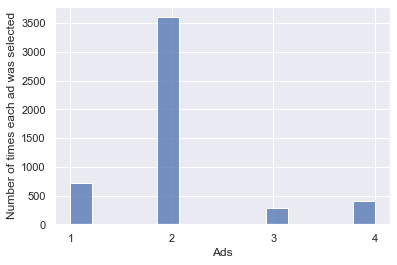

In [166]:
ax = sns.histplot(ads_selected)
ax.set(xlabel='Ads', ylabel='Number of times each ad was selected')
ax.set_xticks(range(0, 4))
ax.set_xticklabels(list(range(1, 11)))
plt.show()

In [167]:
selected = pd.Series(ads_selected).value_counts()
selected.index = selected.index + 1
selected = selected.reset_index().sort_values(by=['index'])
selected.rename({'index': 'Ad'}, axis=1, inplace=True)
selected.rename({0: 'Number of Times Selected'}, axis=1)

,Ad,Number of Times Selected
1,1,718
0,2,3603
3,3,275
2,4,404


In [168]:
total_reward

659

In [169]:
total_reward*100 / max(df.sum())

97.48520710059172

In [170]:
100 - total_reward*100 / max(df.sum())

2.5147928994082775

In [171]:
(total_reward / random_reward - 1) * 100

24.105461393596993

In [172]:
total_reward

659

# UCB

https://www.youtube.com/watch?v=TIlDzLZPyhY

In [143]:
df.head(2)

,Ad 1,Ad 2,Ad 3,Ad 4
0,1,0,0,0
1,0,1,0,1


In [144]:
df.sum()

Ad 1    577
Ad 2    676
Ad 3    503
Ad 4    532
dtype: int64

In [145]:
N = df.shape[0]

d = df.shape[1]

In [146]:
import math

In [147]:
def calculate_upper_bound(wins, num_selections, n):
    average_reward = wins / num_selections
    delta_i = math.sqrt(3/2 * math.log(n + 1) / num_selections)
    upper_bound = average_reward + delta_i
    return upper_bound

In [155]:
# Increase PLOTTING_AT_EVERY_N to update plot less frequently
PLOTTING_AT_EVERY_N = 500

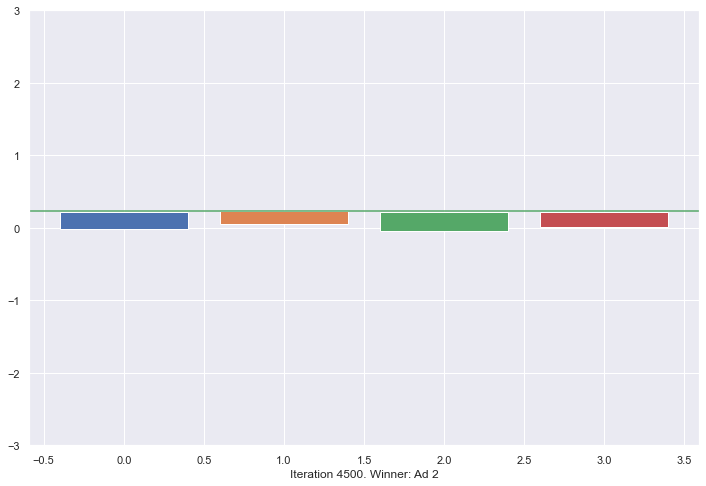

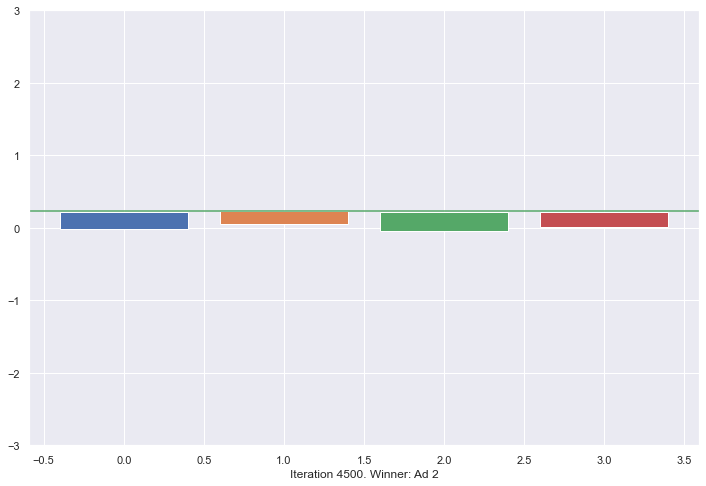

In [156]:
SHOW_PLOT = True

ads_selected = []
number_of_selections_of_machine = [0] * d
number_of_wins = [0] * d
total_reward = 0

fig, ax = plt.subplots(figsize=(12, 8))

overall_min = []
overall_max = []

for n in tqdm(range(0, N)):
    if(SHOW_PLOT):
        if(n % PLOTTING_AT_EVERY_N == 0):

            current_average_rewards = []
            current_bottom_rewards = []

            ax.cla()
            for i in range(0, d):
                if(number_of_selections_of_machine[i] > 0):
                    average_reward_temp = number_of_wins[i] / number_of_selections_of_machine[i]
                    delta_i_temp = math.sqrt(
                        3/2 * math.log(n + 1) / number_of_selections_of_machine[i])
                    upper_bound_temp = average_reward_temp + delta_i_temp
                    current_bottom_rewards.append(average_reward_temp-delta_i_temp)
                else:
                    upper_bound_temp = 0
                    current_bottom_rewards.append(0)
                current_average_rewards.append(upper_bound_temp)

            overall_max.append(max(current_average_rewards))
            overall_min.append(min(current_bottom_rewards))

            for reward in range(len(current_average_rewards)):
                plt.bar(reward, height=current_average_rewards[reward] - current_bottom_rewards[reward],
        bottom=current_bottom_rewards[reward])
            plt.axhline(y=max(current_average_rewards), color='g', linestyle='-')
            ax.set(ylim=(-3, 3))
            winning_ad = current_average_rewards.index(max(current_average_rewards))
            ax.set(xlabel="Iteration " + str(n) + ". Winner: Ad " + str(winning_ad + 1))
            IPython.display.clear_output(wait=True)
            IPython.display.display(plt.gcf())
            time.sleep(0.15)

    ad = 0
    max_upper_bound = 0
    
    upper_bound_values = []
    for i in range(0, d):
        if(number_of_selections_of_machine[i] > 0):
            average_reward = number_of_wins[i] / number_of_selections_of_machine[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) /
                                number_of_selections_of_machine[i])
            upper_bound = average_reward + delta_i
        else:
            # Setting upper bound to be a very large number
            upper_bound = 1e20
        upper_bound_values.append(upper_bound)

    ad = upper_bound_values.index(max(upper_bound_values))
    ads_selected.append(ad)
    number_of_selections_of_machine[ad] = number_of_selections_of_machine[ad] + 1

    reward = df.values[n, ad]
    if reward == 1:
        number_of_wins[ad] = number_of_wins[ad] + 1
    total_reward = total_reward + reward

In [157]:
selected = pd.Series(ads_selected).value_counts()
selected.index = selected.index + 1
selected = selected.reset_index().sort_values(by=['index'])
selected.rename({'index': 'Ad'}, axis=1, inplace=True)
selected.rename({0: 'Number of Times Selected'}, axis=1)

,Ad,Number of Times Selected
3,1,912
0,2,1928
2,3,973
1,4,1187


In [158]:
total_reward

615